In [2]:
import pandas as pd
import numpy as np
from sklearn import cluster
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import dill
import torch
import time
from utils.kmeans_pytorch.kmeans import lloyd, lloyd_batch, kmeans_core

In [3]:
class MorletTrans:
    def __init__(self, w_0, N_f, f_min, f_max, fr=50):
        self.w_0 = w_0
        self.N_f = N_f
        self.f_min = f_min
        self.f_max = f_max
        self.f_array = self.freq(np.arange(1, N_f+1))
        self.fr = fr
        self.data_length = 1000 # Random length initially
    def morlet(self, eta):
        return np.pi**(-0.25)*np.exp(1j*self.w_0*eta)*np.exp(-0.5*eta**2)
    def s(self, f):
        return (self.w_0+np.sqrt(2+self.w_0**2))/(4*np.pi*f)
    def freq(self, i):
        return self.f_max*2**(-1*(i-1)/(self.N_f-1)*np.log2(self.f_max/self.f_min))
    def C(self, s_cons):
        return ((np.pi**(-0.25))/np.sqrt(2*s_cons))*np.exp(((self.w_0-np.sqrt(self.w_0**2+2))**2)/4)
        # return ((np.pi**(-0.25))/np.sqrt(2*s_cons))*np.exp(1/(((self.w_0-np.sqrt(self.w_0**2+2))**2)*4))
    def run(self, data):
        num_bp = data.shape[0]
        num_t = data.shape[-1]
        self.data_length = num_t
        num_dim = data.shape[1]
        t = np.arange(num_t)
        power = np.zeros((num_bp, num_dim, self.f_array.size, num_t)) 
        for bp_i, bp in enumerate(range(num_bp)):
            for axis in range(num_dim):
                if num_t % 2 == 0:
                    y = data[bp_i,axis,:-1] # if even
                else:
                    y = data[bp_i,axis,:] # if odd
                for f_idx, f in enumerate(self.f_array):
                    s_cons = self.s(f)
                    # CWT Transform
                    transform = (1/np.sqrt(s_cons))*np.convolve(y, self.morlet(t/s_cons), mode="same") 
                    power[bp_i,axis,f_idx,:] = (1/self.C(s_cons))*np.absolute(transform)
        return power
    def plot(self, power_bp, save_as_pdf, t_start=0, t_end=100, cmap="OrRd"):
        fig, axes = plt.subplots(power_bp.shape[0], power_bp.shape[1], figsize=(20,115)) # (height, width) 
        # CREATE SUBPLOT
        for bp_i in tqdm(range(power_bp.shape[0])):
            for axis in range(power_bp.shape[1]):
                mesh = axes[bp_i,axis].pcolormesh(power_bp[bp_i,axis,:,t_start:t_end])# , edgecolors='face', linewidths=5
                axes[bp_i,axis].set_title("Wavelet Spectrogram Body Part " + str(bp_i) + " with Axis " + str(axis))
                axes[bp_i,axis].set_xlabel("Time (s)")
                axes[bp_i,axis].set_ylabel("Frequency (Hz)")
                # axes[bp_i,axis].set_yticklabels(np.around(self.f_array, decimals=2), minor=False)
                # fig.colorbar(mesh)
        plt.tight_layout()
        plt.show()
        # SAVE FIGURE AS PDF
        if(save_as_pdf == True):
            f = open("fig/" + 'RENAME_ME' + ".pdf","x")
            fig.savefig("fig/" + 'RENAME_ME' + ".pdf")
            f.close() 
        plt.close(fig)

In [4]:
class ClassifyBehavior():
    def __init__(self, ):
        self.df_data = None 
        self.data = None
        self.power_bp = None
        pass
    def import_data(self, data_path):
        # Import Data
        df = pd.read_hdf(data_path)
        self.df_data = df[df.keys().levels[0][0]].values
        pass
    def rot_trans_data(self):
        # FORMATING DATA
        time_length = len(self.df_data) # t
        self.data = np.swapaxes(self.df_data.reshape((time_length,30,3)).T,0,1) # 30 x 3 x t
        # MAKE POINT 2 ORIGIN
        self.data[:,0:2,:] = self.data[:,0:2,:] - self.data[2,0:2,:]
        # COMPUTE THE CENTER OF AXIS & ANGLE
        axis_vector = self.data[1,:,:]
        axis_angle_deviation = np.sign(axis_vector[0,:])*np.pi/2-np.arctan(axis_vector[1,:]/axis_vector[0,:])
        # ROTATE ALL DATA POINT
        for i in range(30):
            self.data[i,0:2,:] = self.Rotate(self.data[i,0:2,:], axis_angle_deviation)
        pass
    def Rotate(self, data, angle):
        return np.einsum('ijk,jk ->ik', np.array([[np.cos(angle), -1*np.sin(angle)],
                                                 [np.sin(angle), np.cos(angle)]]), data)
    def morlet_transform(self):
        # MORLET TRANSFORM ON BODY PARTS
        MT = MorletTrans(w_0=15, N_f=25, f_min=1, f_max=6, fr=25)
        try:
            self.power_bp = np.append(self.power_bp, MT.run(self.data[:,0:2,:]), axis=3)
        except:
            self.power_bp = MT.run(self.data[:,0:2,:]) 
        # MT.plot(self.power_bp, save_as_pdf=False, t_start=0, t_end=-1)  
        pass
    def k_means(self):
        # FORMAT DATA
        data_cluster = self.power_bp.reshape((3000, self.power_bp.shape[-1])).T
        # Run K-Means Cluster
        kmeans = KMeansCluster(min_k=3,max_k=80,epoch=1,rand_seed=0)
        kmeans.run(data_cluster)
        kmeans.plot()
        pass
    def spectral_clustering(self):
        data_cluster = self.power_bp.reshape((3000, self.power_bp.shape[-1])).T
        SCluster = SpectralClustering(min_k=2, max_k=80, epoch=1, rand_seed=0)
        SCluster_affinity = SCluster.run(data_cluster)
        SCluster.plot()
        pass

In [6]:
# ALGORITHM TO CLASSIFY BEHAVIOR
CB = ClassifyBehavior()
data_pathnames = glob.glob('Data/Entire_Video_Data/*.h5')
power_datapath = "Data/PowerSpectogram_Data/CB_power_ALLdata_60bp_25fBin.npy"

for data_path in tqdm(data_pathnames):
    CB.import_data(data_path)
    print("FINISHED Importing Data")
    CB.rot_trans_data()
    print("FINISHED Rotating & Translating Data")
    CB.morlet_transform()
    print("FINISHED Morlet Transform")
    
np.save(power_datapath, CB.power_bp[:,:,:,:])

  0%|          | 0/94 [00:00<?, ?it/s]

FINISHED Importing Data
FINISHED Rotating & Translating Data


  1%|          | 1/94 [02:44<4:15:06, 164.59s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


  2%|▏         | 2/94 [02:56<3:02:21, 118.93s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


  3%|▎         | 3/94 [04:00<2:34:59, 102.19s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


  4%|▍         | 4/94 [04:17<1:54:54, 76.61s/it] 

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


  5%|▌         | 5/94 [04:21<1:21:19, 54.82s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


  6%|▋         | 6/94 [08:25<2:43:43, 111.63s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


  7%|▋         | 7/94 [08:29<1:55:08, 79.41s/it] 

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


  9%|▊         | 8/94 [08:39<1:23:52, 58.52s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 10%|▉         | 9/94 [08:43<59:55, 42.30s/it]  

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 11%|█         | 10/94 [08:47<42:59, 30.70s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 12%|█▏        | 11/94 [08:56<33:40, 24.35s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 13%|█▎        | 12/94 [09:17<31:51, 23.31s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 14%|█▍        | 13/94 [09:20<23:04, 17.09s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 15%|█▍        | 14/94 [09:30<19:52, 14.91s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 16%|█▌        | 15/94 [09:45<19:56, 15.14s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 17%|█▋        | 16/94 [12:07<1:08:51, 52.97s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 18%|█▊        | 17/94 [12:13<50:11, 39.11s/it]  

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 19%|█▉        | 18/94 [12:22<37:54, 29.93s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 20%|██        | 19/94 [12:49<36:29, 29.19s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 21%|██▏       | 20/94 [13:26<38:37, 31.32s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 22%|██▏       | 21/94 [13:29<27:48, 22.85s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 23%|██▎       | 22/94 [13:30<19:38, 16.37s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 24%|██▍       | 23/94 [14:03<25:27, 21.51s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 26%|██▌       | 24/94 [14:12<20:38, 17.70s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 27%|██▋       | 25/94 [14:29<20:07, 17.50s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 28%|██▊       | 26/94 [14:44<18:45, 16.55s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 29%|██▊       | 27/94 [14:59<18:10, 16.27s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 30%|██▉       | 28/94 [16:00<32:42, 29.74s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 31%|███       | 29/94 [16:02<22:59, 21.22s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 32%|███▏      | 30/94 [16:42<28:42, 26.92s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 33%|███▎      | 31/94 [16:50<22:26, 21.37s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 34%|███▍      | 32/94 [17:08<20:52, 20.20s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 35%|███▌      | 33/94 [17:11<15:28, 15.22s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 36%|███▌      | 34/94 [17:26<14:56, 14.94s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 37%|███▋      | 35/94 [18:03<21:22, 21.74s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 38%|███▊      | 36/94 [18:14<17:47, 18.40s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 39%|███▉      | 37/94 [18:38<19:09, 20.16s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 40%|████      | 38/94 [18:51<16:48, 18.01s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 41%|████▏     | 39/94 [19:44<25:59, 28.36s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 43%|████▎     | 40/94 [19:50<19:29, 21.65s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 44%|████▎     | 41/94 [19:52<14:01, 15.89s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 45%|████▍     | 42/94 [21:51<40:35, 46.84s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 46%|████▌     | 43/94 [22:18<34:44, 40.87s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 47%|████▋     | 44/94 [22:40<29:13, 35.08s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 48%|████▊     | 45/94 [22:59<24:41, 30.23s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 49%|████▉     | 46/94 [23:20<21:58, 27.48s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 50%|█████     | 47/94 [23:42<20:24, 26.06s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 51%|█████     | 48/94 [24:04<18:50, 24.58s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 52%|█████▏    | 49/94 [24:34<19:38, 26.20s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 53%|█████▎    | 50/94 [24:50<17:06, 23.34s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 54%|█████▍    | 51/94 [25:18<17:38, 24.61s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 55%|█████▌    | 52/94 [25:19<12:21, 17.64s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 56%|█████▋    | 53/94 [25:20<08:37, 12.63s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 57%|█████▋    | 54/94 [25:27<07:21, 11.05s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 59%|█████▊    | 55/94 [26:28<16:51, 25.95s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 60%|█████▉    | 56/94 [26:58<17:13, 27.20s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 61%|██████    | 57/94 [27:11<14:00, 22.72s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 62%|██████▏   | 58/94 [27:50<16:43, 27.88s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 63%|██████▎   | 59/94 [28:25<17:30, 30.02s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 64%|██████▍   | 60/94 [29:16<20:26, 36.06s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 65%|██████▍   | 61/94 [29:18<14:15, 25.93s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 66%|██████▌   | 62/94 [29:25<10:47, 20.24s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 67%|██████▋   | 63/94 [29:28<07:47, 15.08s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 68%|██████▊   | 64/94 [29:37<06:34, 13.16s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 69%|██████▉   | 65/94 [30:08<08:56, 18.49s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 70%|███████   | 66/94 [30:17<07:20, 15.74s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 71%|███████▏  | 67/94 [30:35<07:23, 16.42s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 72%|███████▏  | 68/94 [30:44<06:08, 14.19s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 73%|███████▎  | 69/94 [31:10<07:26, 17.88s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 74%|███████▍  | 70/94 [31:57<10:37, 26.58s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 76%|███████▌  | 71/94 [32:24<10:11, 26.58s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 77%|███████▋  | 72/94 [32:38<08:21, 22.82s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 78%|███████▊  | 73/94 [33:11<09:04, 25.94s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 79%|███████▊  | 74/94 [33:37<08:39, 25.95s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 80%|███████▉  | 75/94 [33:48<06:46, 21.38s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 81%|████████  | 76/94 [33:59<05:32, 18.45s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 82%|████████▏ | 77/94 [34:09<04:27, 15.71s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 83%|████████▎ | 78/94 [34:12<03:13, 12.09s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 84%|████████▍ | 79/94 [34:16<02:23,  9.55s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 85%|████████▌ | 80/94 [34:18<01:41,  7.24s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 86%|████████▌ | 81/94 [34:25<01:33,  7.17s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 87%|████████▋ | 82/94 [34:30<01:17,  6.43s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 88%|████████▊ | 83/94 [34:33<01:02,  5.65s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 89%|████████▉ | 84/94 [34:51<01:32,  9.23s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 90%|█████████ | 85/94 [36:14<04:42, 31.43s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 91%|█████████▏| 86/94 [36:15<02:59, 22.38s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 93%|█████████▎| 87/94 [36:35<02:31, 21.66s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 94%|█████████▎| 88/94 [36:44<01:47, 17.86s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 95%|█████████▍| 89/94 [36:46<01:05, 13.09s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 96%|█████████▌| 90/94 [37:05<00:58, 14.68s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 97%|█████████▋| 91/94 [37:15<00:40, 13.40s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 98%|█████████▊| 92/94 [37:22<00:22, 11.45s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


 99%|█████████▉| 93/94 [37:34<00:11, 11.46s/it]

FINISHED Morlet Transform
FINISHED Importing Data
FINISHED Rotating & Translating Data


100%|██████████| 94/94 [37:35<00:00,  8.47s/it]

FINISHED Morlet Transform


In [11]:
CB.power_bp[:,:,:,0:100].shape

(30, 2, 25, 100)

# Save Data Outside Notebook

* 50 min for morlet transform
* probably another 2 hours for the other two cluster
* total about 3 hours

* $Framerate = 50Hz$
* Analyze frequency from $f_{min}=1Hz$ to $f_{max}=25Hz$
* $N_f = 25$ number of frequency bins
* These are the following frequencies analyzed: {{MT.f_array}}
* Power Spectrum should always be positive

# VERIFY KMEANS++ CLUSTER WORKS

In [5]:
import pandas as pd
import numpy as np
from sklearn import cluster
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import dill
import torch
import time
from utils.kmeans_pytorch.kmeans import lloyd, lloyd_batch, kmeans_core

/home/dong/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


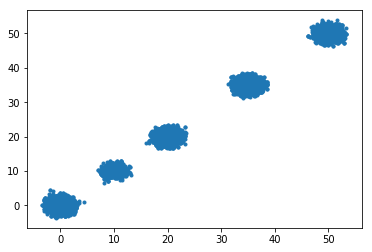

In [6]:
X = [np.random.randn(10000, 2), np.random.randn(1000, 2)+10, np.random.randn(10000, 2)+20,np.random.randn(10000, 2)+35,np.random.randn(10000, 2)+50]
X = np.concatenate(X, axis=0)
X = X[np.random.choice(range(X.shape[0]), X.shape[0])]
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], '.')
fig.show()

/home/dong/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 NVS 315 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
100%|██████████| 41/41 [00:00<00:00, 1981.52it/s]


100%|██████████| 41/41 [00:00<00:00, 1925.69it/s]


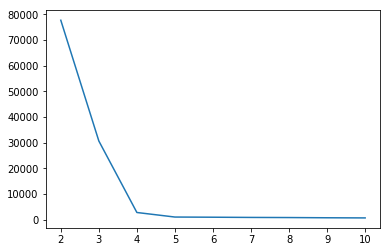

In [7]:
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH
min_k = 2
max_k = 10
sse = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=X, device=2, batch_size=1000, epochs=10, random_state=2)
    sse[k_i] = km.run()
    
# print("centroids: ", km.cent)
# plt.scatter(X[:,0], X[:,1], c=km.idx,marker="o")
# plt.show()
k_list = range(min_k, max_k+1)
plt.plot(k_list,sse)
plt.show()

# KMEANS++ CLUSTER ON REAL DATA

100%|██████████| 1/1 [00:00<00:00, 770.30it/s]


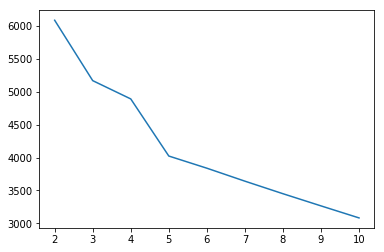

In [4]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_100data_60bp_50fBin.npy')
data_cluster = data_test.reshape((3000, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 2
max_k = 10
sse = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=1000, epochs=10, all_cuda=False, random_state=2)
    sse[k_i] = km.run()

k_list = range(min_k, max_k+1)
plt.plot(k_list,sse)
plt.show()

100%|██████████| 1/1 [00:00<00:00, 174.20it/s]


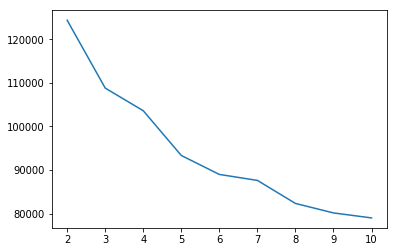

In [6]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_1000data_60bp_50fBin.npy')
data_cluster = data_test.reshape((3000, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 2
max_k = 10
sse = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=1000, epochs=10, all_cuda=False, random_state=2)
    sse[k_i] = km.run()

k_list = range(min_k, max_k+1)
plt.plot(k_list,sse)
plt.show()

100%|██████████| 10/10 [00:00<00:00, 306.00it/s]


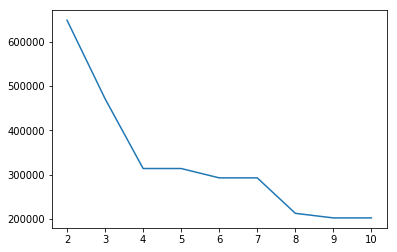

In [8]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_10000data_60bp_50fBin.npy')
data_cluster = data_test.reshape((3000, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 2
max_k = 10
sse = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=1000, epochs=10, random_state=2)
    sse[k_i] = km.run()

k_list = range(min_k, max_k+1)
plt.plot(k_list,sse)
plt.show()

100%|██████████| 5/5 [00:00<00:00, 20.63it/s]


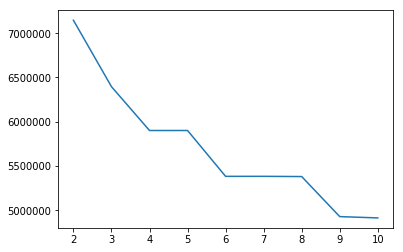

In [9]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_50000data_60bp_50fBin.npy')
data_cluster = data_test.reshape((3000, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 2
max_k = 10
sse = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=10000, epochs=10, all_cuda=False, random_state=2)
    sse[k_i] = km.run()

k_list = range(min_k, max_k+1)
plt.plot(k_list,sse)
plt.show()


[epoch:1	 iter:43] 	 k:2	 distance:3514.770: 100%|██████████| 44/44 [00:01<00:00, 23.50it/s]

[epoch:2	 iter:26] 	 k:2	 distance:5656.220:  57%|█████▋    | 25/44 [00:00<00:00, 23.68it/s]


[epoch:3	 iter:43] 	 k:2	 distance:3514.770: 100%|██████████| 44/44 [00:01<00:00, 35.23it/s]

[epoch:5	 iter:30] 	 k:2	 distance:3514.197:  64%|██████▎   | 28/44 [00:00<00:00, 33.21it/s]


[epoch:7	 iter:43] 	 k:2	 distance:3514.770: 100%|██████████| 44/44 [00:01<00:00, 35.33it/s]

[epoch:8	 iter:34] 	 k:2	 distance:3849.317:  73%|███████▎  | 32/44 [00:01<00:00, 33.55it/s]


[epoch:8	 iter:43] 	 k:2	 distance:3514.770: 100%|██████████| 44/44 [00:01<00:00, 34.69it/s]

[epoch:9	 iter:43] 	 k:2	 distance:3514.770: 100%|██████████| 44/44 [00:01<00:00, 34.98it/s]

[epoch:0	 iter:43] 	 k:3	 distance:20883.781: 100%|██████████| 44/44 [00:01<00:00, 32.41it/s]

[epoch:1	 iter:31] 	 k:3	 distance:18670.752:  68%|██████▊   | 30/44 [00:01<00:00, 30.72it/s]


[epoch:4	 iter:30] 	 k:3	 distance:22350.203:  66%|██████▌   | 29/44 [00:01<00:00, 30.29it/s]


[epoch:5	 iter:43] 	 k:3	 distance:20883.781: 100%|██████████| 44/44 [00:01<00:00, 31.82it/s]

[epoch:7	 iter:29] 	 k:3	 distance:23586.133:  68%|██████▊   | 30/44 [00:00<00:00, 30.39it/s]


[epoch:8	 iter:43] 	 k:3	 distance:20883.781: 100%|██████████| 44/44 [00:01<00:00, 31.71it/s]

[epoch:0	 iter:23] 	 k:4	 distance:24732.592:  48%|████▊     | 21/44 [00:00<00:00, 27.79it/s]


[epoch:3	 iter:16] 	 k:4	 distance:11241.700:  34%|███▍      | 15/44 [00:00<00:01, 27.81it/s]


[epoch:6	 iter:9] 	 k:4	 distance:20421.055:  20%|██        | 9/44 [00:00<00:01, 27.64it/s]


[epoch:9	 iter:2] 	 k:4	 distance:29901.174:   7%|▋         | 3/44 [00:00<00:01, 28.64it/s]


100%|██████████| 44/44 [00:01<00:00, 34.75it/s]

[epoch:1	 iter:35] 	 k:5	 distance:29712.799:  82%|████████▏ | 36/44 [00:01<00:00, 25.34it/s]


[epoch:4	 iter:29] 	 k:5	 distance:38723.148:  61%|██████▏   | 27/44 [00:01<00:00, 25.59it/s]


[epoch:7	 iter:22] 	 k:5	 distance:23289.262:  48%|████▊     | 21/44 [00:00<00:00, 25.62it/s]


[epoch:0	 iter:9] 	 k:6	 distance:27793.664:  20%|██        | 9/44 [00:00<00:01, 23.18it/s]


[epoch:3	 iter:2] 	 k:6	 distance:37098.969:   7%|▋         | 3/44 [00:00<00:01, 24.26it/s]


[epoch:5	 iter:40] 	 k:6	 distance:37896.074:  89%|████████▊ | 39/44 [00:01<00:00, 23.72it/s]


[epoch:8	 iter:33] 	 k:6	 distance:52682.906:  75%|███████▌  | 33/44 [00:01<00:00, 23.79it/s]


[epoch:1	 iter:19] 	 k:7	 distance:51307.488:  41%|████      | 18/44 [00:00<00:01, 22.14it/s]


[epoch:4	 iter:12] 	 k:7	 distance:54057.055:  27%|██▋       | 12/44 [00:00<00:01, 22.07it/s]


[epoch:7	 iter:5] 	 k:7	 distance:46401.867:  14%|█▎        | 6/44 [00:00<00:01, 21.96it/s]


[epoch:9	 iter:43] 	 k:7	 distance:57320.930:  95%|█████████▌| 42/44 [00:01<00:00, 22.16it/s]


[epoch:1	 iter:43] 	 k:8	 distance:69871.398: 100%|██████████| 44/44 [00:02<00:00, 22.38it/s]

[epoch:2	 iter:30] 	 k:8	 distance:68056.406:  68%|██████▊   | 30/44 [00:01<00:00, 20.70it/s]


[epoch:5	 iter:23] 	 k:8	 distance:42360.484:  55%|█████▍    | 24/44 [00:01<00:00, 20.76it/s]


[epoch:8	 iter:16] 	 k:8	 distance:49971.496:  39%|███▊      | 17/44 [00:00<00:01, 20.73it/s]


[epoch:9	 iter:43] 	 k:8	 distance:74167.406: 100%|██████████| 44/44 [00:02<00:00, 22.10it/s]

[epoch:0	 iter:43] 	 k:9	 distance:54342.156:  98%|█████████▊| 43/44 [00:02<00:00, 19.51it/s]


[epoch:3	 iter:23] 	 k:9	 distance:42067.980:  50%|█████     | 22/44 [00:01<00:01, 19.42it/s]


[epoch:6	 iter:3] 	 k:9	 distance:44156.262:   5%|▍         | 2/44 [00:00<00:02, 19.75it/s]


[epoch:8	 iter:27] 	 k:9	 distance:57882.449:  59%|█████▉    | 26/44 [00:01<00:00, 19.49it/s]


[epoch:1	 iter:1] 	 k:10	 distance:48563.758:   0%|          | 0/44 [00:00<?, ?it/s]


[epoch:3	 iter:23] 	 k:10	 distance:51456.668:  55%|█████▍    | 24/44 [00:01<00:01, 18.22it/s]


[epoch:6	 iter:2] 	 k:10	 distance:58114.977:   5%|▍         | 2/44 [00:00<00:02, 18.81it/s]


[epoch:8	 iter:25] 	 k:10	 distance:60906.762:  55%|█████▍    | 24/44 [00:01<00:01, 18.27it/s]


100%|██████████| 44/44 [00:02<00:00, 20.73it/s]

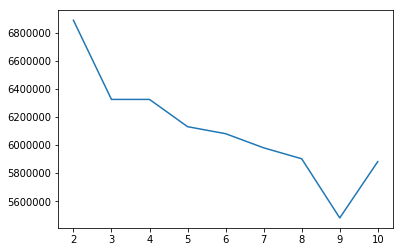

In [11]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_ALLdata_60bp_50fBin.npy')
data_cluster = data_test.reshape((3000, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 2
max_k = 10
sse = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=10000, epochs=10, all_cuda=False, random_state=2)
    sse[k_i] = km.run()

k_list = range(min_k, max_k+1)
plt.plot(k_list,sse)
plt.show()

# Increase Number of Clusters Tested

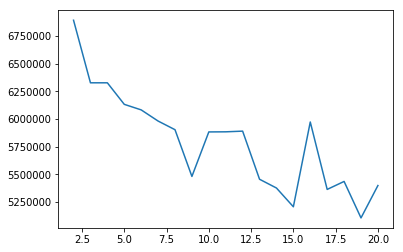

In [15]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_ALLdata_60bp_50fBin.npy')
data_cluster = data_test.reshape((3000, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 2
max_k = 20
sse = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=10000, epochs=10, all_cuda=False, random_state=2)
    sse[k_i] = km.run()

    
k_list_50 = np.arange(min_k, max_k+1)
plt.plot(k_list_50, sse)
plt.xticks(k_list_50)
plt.show()

In [26]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_ALLdata_60bp_50fBin.npy')
data_cluster = data_test.reshape((3000, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 23
max_k = 25

sse_50_ab = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=10000, epochs=10, all_cuda=False, random_state=2)
    sse_50_ab[k_i] = km.run()

k_list_50 = np.arange(min_k, max_k+1)
plt.plot(k_list_50, sse_50_ab)
plt.xticks(k_list_50)
plt.show()


  0%|          | 0/44 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.57 GiB (GPU 2; 10.91 GiB total capacity; 5.37 GiB already allocated; 2.05 GiB free; 3.02 GiB cached)

(19,)
(19,)


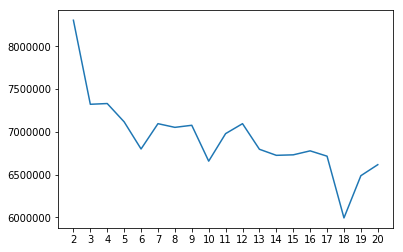

In [22]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_ALLdata_60bp_25fBin.npy')
bp,coord,fbin,num_data = data_test.shape
data_cluster = data_test.reshape((bp*coord*fbin, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 2
max_k = 20
sse_25 = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=10000, epochs=10, all_cuda=False, random_state=2)
    sse_25[k_i] = km.run()

k_list_25 = np.arange(min_k, max_k+1)
plt.plot(k_list_25, sse_25)
plt.xticks(k_list_25)
plt.show()

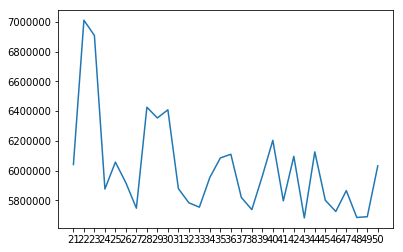

In [25]:
data_test = np.load('Data/PowerSpectogram_Data/CB_power_ALLdata_60bp_25fBin.npy')
bp,coord,fbin,num_data = data_test.shape
data_cluster = data_test.reshape((bp*coord*fbin, data_test.shape[-1])).transpose(1,0)
# YOU MUST RANDOMIZE YOUR DATA BEFORE YOU SEND YOUR DATA INTO BATCH!!!
min_k = 21
max_k = 50
sse_25_b = np.zeros(max_k-min_k+1)
for k_i, k in enumerate(range(min_k, max_k+1)):
    km = kmeans_core(k=k, data_array=data_cluster, device=2, batch_size=10000, epochs=10, all_cuda=False, random_state=2)
    sse_25_b[k_i] = km.run()
    
k_list_25_b = np.arange(min_k, max_k+1)
plt.plot(k_list_25_b, sse_25_b)
plt.xticks(k_list_25_b)
plt.show()

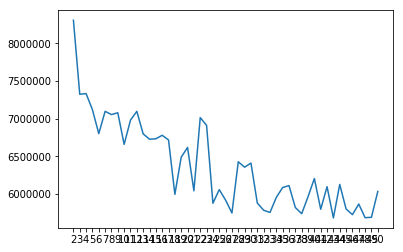

In [27]:
plt.plot(np.concatenate((k_list_25, k_list_25_b), axis=0), np.concatenate((sse_25, sse_25_b), axis=0))
plt.xticks(np.concatenate((k_list_25, k_list_25_b), axis=0))
plt.show()

# Spectral Clustering